# Layerwise Training

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
from glob import glob
import os
import shutil
from network import DenseLayer, FeedForwardNet

# 1. Datasets

In [2]:
mnist_tf = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2, fill=0, padding_mode='constant'),
    torchvision.transforms.ToTensor()
])

cifar_tf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

mnist_test = torchvision.datasets.MNIST('./', train=False, transform=mnist_tf)
cifar_test = torchvision.datasets.CIFAR10('./', train=False, transform=cifar_tf) 

# 2. Evaluation

In [39]:
PATHS = [
    'ep_10_lr_0.001_b_32_l_trl_n_ff_d_cifar10_layer_3_full_1',
    'ep_10_lr_0.001_b_32_l_trl_n_ff_d_mnist_layer_3_full_1',
    'ep_50_lr_0.001_b_32_l_ce_n_ff_d_cifar10_layer_0_full_1',
    'ep_50_lr_0.001_b_32_l_ce_n_ff_d_mnist_layer_0_full_1',
    'ep_50_lr_0.01_b_32_l_trl_n_ff_d_cifar10_layer_3_full_0',
    'ep_50_lr_0.01_b_32_l_trl_n_ff_d_mnist_layer_3_full_0'
]

PATH = PATHS[2]

FULL = int(PATH.split('_')[-1])
LAYER = int(PATH.split('_')[-3])
MODEL = PATH.split('_')[-7]
LOSS = PATH.split('_')[7]
DATASET = PATH.split('_')[11]

ACTIVATION = 'sigmoid' if LOSS == 'trl' else 'tanh'
CLASS_NUM = len(mnist_test.classes) if DATASET == 'mnist' else len(cifar_test.classes)

test_l = DataLoader(mnist_test if DATASET == 'mnist' else cifar_test, batch_size=16, shuffle=False, num_workers=0)

In [40]:
if MODEL == 'ff':
    
    network = FeedForwardNet(CLASS_NUM, ACTIVATION, DATASET)
    layers = network.network()
    
    losses = {}
    
    if FULL == 0:
        
        for i in range(LAYER+1):
            
            load_path = glob('models/*l_{}_n_ff_d_{}_layer_{}_full_0/*'.format(LOSS, DATASET, i))[0] 
            print("LOAD: " + load_path)
            load_dict = torch.load(load_path)
            layers[i].load_state_dict(load_dict['state_dict'])
            losses[i] = {'train': load_dict['train_loss'], 'val': load_dict['val_loss']}

        model = nn.Sequential(*layers)
        
    else:
        
        if LAYER == len(layers)-1:
            
            for i in range(LAYER):
                load_path = glob('models/*l_{}_n_ff_d_{}_layer_{}_full_0/*'.format(LOSS, DATASET, i))[0] 
                load_dict = torch.load(load_path)
                losses[i] = {'train': load_dict['train_loss'], 'val': load_dict['val_loss']}
            

        model = nn.Sequential(*layers)
        load_path = glob('models/' + PATH + '/*')[0]
        print("LOAD: " + load_path)
        load_dict = torch.load(load_path)
        model.load_state_dict(load_dict['state_dict'])
        
        losses[len(layers)-1] = {'train': load_dict['train_loss'], 'val': load_dict['val_loss']}

LOAD: models/ep_50_lr_0.001_b_32_l_ce_n_ff_d_cifar10_layer_0_full_1/ep_48.pth.tar


# 3. Test Accuracy

In [41]:
model.eval()
with torch.no_grad(): 
    
    acc = 0.
    ce = 0.
    
    for inputs, target in test_l:
        
        predicted = model(inputs.cuda())
        pred_class = predicted.argmax(dim=1).cpu()
        
        acc += ((pred_class == target).sum().item() / len(inputs))
        ce += nn.CrossEntropyLoss()(predicted, target.cuda())
        
    print("MODEL: ", PATH)
    print("ACCURACY: {:.3f} | CE: {:.3f}".format(acc/(len(test_l)), ce/len(test_l)))

MODEL:  ep_50_lr_0.001_b_32_l_ce_n_ff_d_cifar10_layer_0_full_1
ACCURACY: 0.661 | CE: 0.986


# 4. Results

## MNIST

### 1 - Train layers separately (the last layer excluded) and train the last layer with previous layers for a few epochs.

- `TEST SET ACCURACY`: __0.953__
- `TEST SET CE`: __0.154__

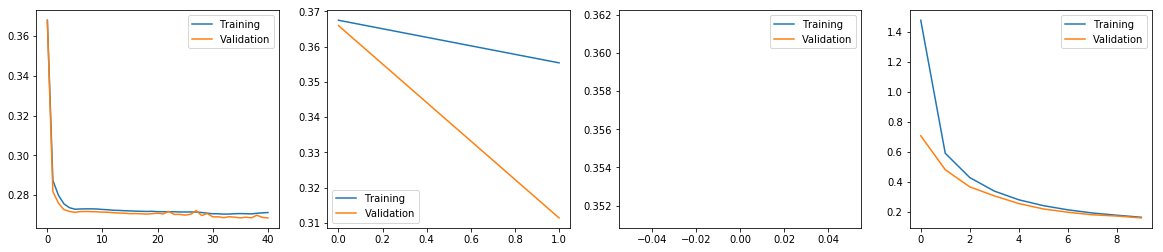

In [14]:
f, ax = plt.subplots(1,4,figsize=(20,4))

for i in range(4):
    ax[i].plot(losses[i]['train'], label='Training')
    ax[i].plot(losses[i]['val'], label='Validation')
    ax[i].legend()

### 2 - Train layers separately (the last layer included).

- `TEST SET ACCURACY`: __0.103__
- `TEST SET CE`: __2.303__

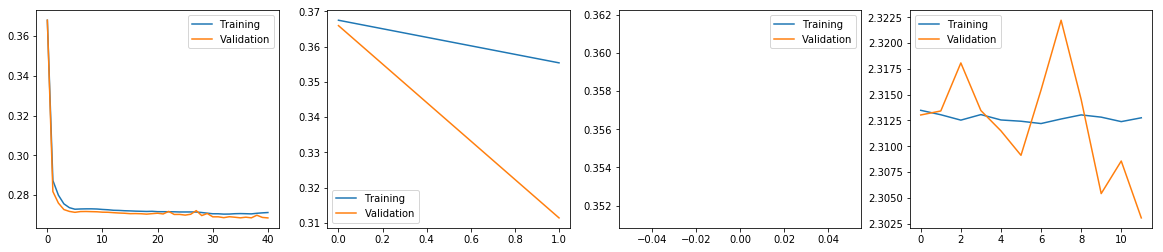

In [18]:
f, ax = plt.subplots(1,4,figsize=(20,4))

for i in range(4):
    ax[i].plot(losses[i]['train'], label='Training')
    ax[i].plot(losses[i]['val'], label='Validation')
    ax[i].legend()

### 3 - Train the whole network

- `TEST SET ACCURACY`: __0.976__
- `TEST SET CE`: __0.08__

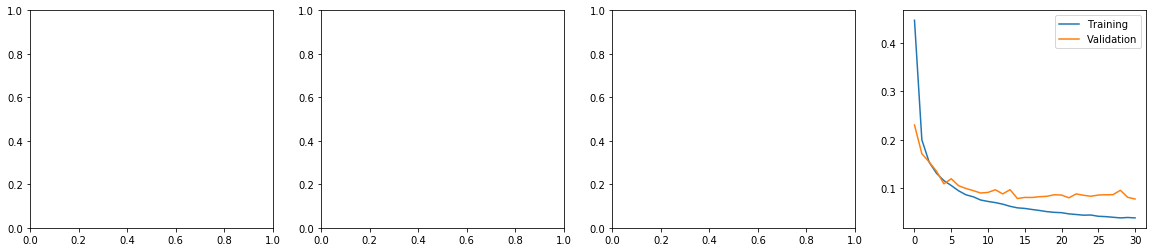

In [25]:
f, ax = plt.subplots(1,4,figsize=(20,4))

ax[-1].plot(losses[len(layers)-1]['train'], label='Training')
ax[-1].plot(losses[len(layers)-1]['val'], label='Validation')
ax[-1].legend()

***

***

## CIFAR-10

### 1 - Train layers separately (the last layer excluded) and train the last layer with previous layers for a few epochs.

- `TEST SET ACCURACY`: __0.466__
- `TEST SET CE`: __1.498__

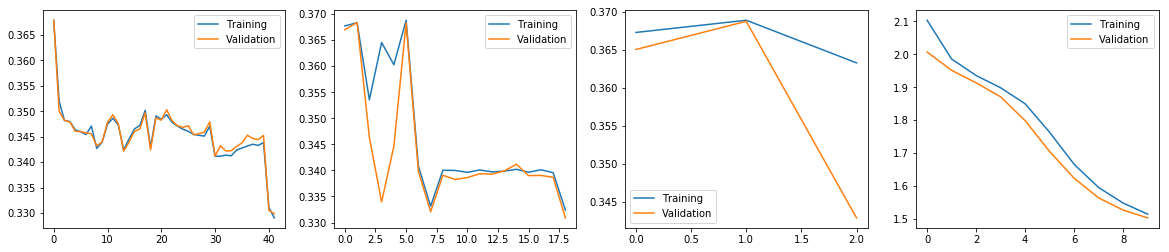

In [32]:
f, ax = plt.subplots(1,4,figsize=(20,4))

for i in range(4):
    ax[i].plot(losses[i]['train'], label='Training')
    ax[i].plot(losses[i]['val'], label='Validation')
    ax[i].legend()

### 2 - Train layers separately (the last layer included).

- `TEST SET ACCURACY`: __0.101__
- `TEST SET CE`: __2.429__

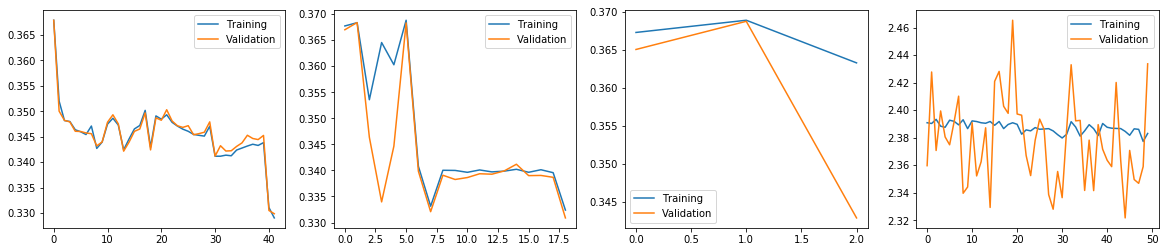

In [38]:
f, ax = plt.subplots(1,4,figsize=(20,4))

for i in range(4):
    ax[i].plot(losses[i]['train'], label='Training')
    ax[i].plot(losses[i]['val'], label='Validation')
    ax[i].legend()

### 3 - Train the whole network

- `TEST SET ACCURACY`: __0.661__
- `TEST SET CE`: __0.986__

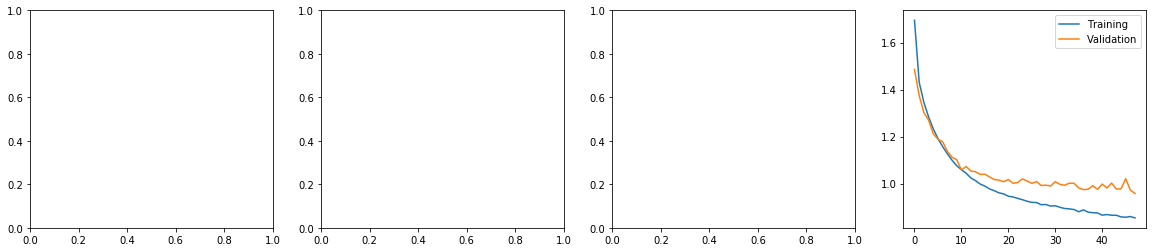

In [42]:
f, ax = plt.subplots(1,4,figsize=(20,4))

ax[-1].plot(losses[len(layers)-1]['train'], label='Training')
ax[-1].plot(losses[len(layers)-1]['val'], label='Validation')
ax[-1].legend()